In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, GRU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model

In [4]:
df = pd.read_csv("C:\\Users\\aadit\\kaggle\\input\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\Edge-IIoTset dataset\Selected dataset for ML and DL\\DNN-EdgeIIoT-dataset.csv", low_memory = False)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\aadit\AppData\Local\Temp\ipykernel_35996\3249241707.py:1: SyntaxWarning: invalid escape sequence '\S'
  df = pd.read_csv("C:\\Users\\aadit\\kaggle\\input\\edgeiiotset-cyber-security-dataset-of-iot-iiot\\Edge-IIoTset dataset\Selected dataset for ML and DL\\DNN-EdgeIIoT-dataset.csv", low_memory = False)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2219201 entries, 0 to 2219200
Data columns (total 63 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   frame.time                 object 
 1   ip.src_host                object 
 2   ip.dst_host                object 
 3   arp.dst.proto_ipv4         object 
 4   arp.opcode                 float64
 5   arp.hw.size                float64
 6   arp.src.proto_ipv4         object 
 7   icmp.checksum              float64
 8   icmp.seq_le                float64
 9   icmp.transmit_timestamp    float64
 10  icmp.unused                float64
 11  http.file_data             object 
 12  http.content_length        float64
 13  http.request.uri.query     object 
 14  http.request.method        object 
 15  http.referer               object 
 16  http.request.full_uri      object 
 17  http.request.version       object 
 18  http.response              float64
 19  http.tls_port              float64
 20  tc

In [6]:
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_TCP', 'DDoS')
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_UDP', 'DDoS')
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_HTTP', 'DDoS')
df['Attack_type'] = df['Attack_type'].str.replace('DDoS_ICMP', 'DDoS')

df['Attack_type'] = df['Attack_type'].str.replace('Port_Scanning', 'Scanning')
df['Attack_type'] = df['Attack_type'].str.replace('Fingerprinting', 'Scanning')
df['Attack_type'] = df['Attack_type'].str.replace('Vulnerability_scanner', 'Scanning')

df['Attack_type'] = df['Attack_type'].str.replace('MITM', 'MITM')

df['Attack_type'] = df['Attack_type'].str.replace('XSS', 'Injection')
df['Attack_type'] = df['Attack_type'].str.replace('SQL_injection', 'Injection')
df['Attack_type'] = df['Attack_type'].str.replace('Uploading', 'Injection')

df['Attack_type'] = df['Attack_type'].str.replace('Backdoor', 'Malware')
df['Attack_type'] = df['Attack_type'].str.replace('Password', 'Malware')
df['Attack_type'] = df['Attack_type'].str.replace('Ransomware', 'Malware')

In [7]:
print(df['Attack_type'].value_counts())

Attack_type
Normal       1615643
DDoS          337977
Injection     104752
Malware        85940
Scanning       73675
MITM            1214
Name: count, dtype: int64


In [8]:
# Creating a dictionary of Types
attacks = {'Normal':0, 'DDoS':1, 'Scanning':2, 'Injection':3, 'MITM':4, 'Malware':5}
df['Attack_type'] = df['Attack_type'].map(attacks)

In [9]:
X = df.drop(columns=['Attack_label', 'Attack_type'])
y = df['Attack_type']

In [12]:
# Apply the Chi-Squared test
X = X.select_dtypes(include=[np.number])
chi_selector = SelectKBest(chi2, k='all')  # Set k to the desired number of features
X_kbest = chi_selector.fit_transform(X, y)

In [13]:
# Get the scores for each feature
chi_scores = chi_selector.scores_

# Combine scores with feature names
chi_scores = pd.DataFrame({'feature': X.columns, 'score': chi_scores})

# Sort the features by their scores
chi_scores = chi_scores.sort_values(by='score', ascending=False)

print(chi_scores)

                      feature         score
10                tcp.ack_raw  3.602882e+14
9                     tcp.ack  1.472532e+14
20                    tcp.seq  7.141620e+12
22                 udp.stream  8.887172e+11
4     icmp.transmit_timestamp  1.859662e+11
24               dns.qry.name  9.108681e+10
3                 icmp.seq_le  2.338326e+10
2               icmp.checksum  2.113493e+10
16                tcp.dstport  8.229687e+09
11               tcp.checksum  5.160706e+09
19                    tcp.len  2.717837e+08
25                 dns.qry.qu  1.697608e+08
6         http.content_length  1.460536e+08
21                   udp.port  2.375369e+07
32              mqtt.hdrflags  9.924011e+06
23             udp.time_delta  4.111967e+06
17                  tcp.flags  3.261274e+06
33                   mqtt.len  1.643743e+06
37             mqtt.topic_len  7.442977e+05
35               mqtt.msgtype  6.202507e+05
7               http.response  4.228090e+05
18              tcp.flags.ack  1

In [14]:
selected_features = chi_scores['feature'].tolist()[:93]  # Select top k features

In [15]:
# Split the data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Split the training data further into train (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [16]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1553440, 42)
X_val shape: (221920, 42)
X_test shape: (443841, 42)


In [17]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
def cnn_lstm_model(input_shape, num_classes):
    
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),        
        MaxPooling1D(pool_size=2),
        
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        
        LSTM(64, return_sequences=False),
        
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [19]:
input_shape = (X_train.shape[1], 1)
num_classes = 6
model = cnn_lstm_model(input_shape, num_classes)
model.summary()
plot_model(model)

c:\Users\aadit\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,454 (189.27 KB)

 Trainable params: 48,454 (189.27 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [20]:
train_start_time = time.time()
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)
# Record the ending time
train_end_time = time.time()

# Record the starting time for testing
test_start_time = time.time()
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, batch_size=32)
# Record the ending time for testing
test_end_time = time.time()

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Calculate and print the training time
train_time = train_end_time - train_start_time
print(f"Training time: {train_time:.2f} seconds")

# Calculate and print the testing time
test_time = test_end_time - test_start_time
print(f"Testing time: {test_time:.2f} seconds")

Epoch 1/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 2061s 42ms/step - accuracy: 0.9091 - loss: 0.3022 - val_accuracy: 0.9439 - val_loss: 0.1606
Epoch 2/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 1172s 24ms/step - accuracy: 0.9450 - loss: 0.1581 - val_accuracy: 0.9507 - val_loss: 0.1390
Epoch 3/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 327s 7ms/step - accuracy: 0.9489 - loss: 0.1474 - val_accuracy: 0.9528 - val_loss: 0.1356
Epoch 4/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 324s 7ms/step - accuracy: 0.9506 - loss: 0.1434 - val_accuracy: 0.9504 - val_loss: 0.1407
Epoch 5/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 322s 7ms/step - accuracy: 0.9515 - loss: 0.1400 - val_accuracy: 0.9536 - val_loss: 0.1337
Epoch 6/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 320s 7ms/step - accuracy: 0.9521 - loss: 0.1386 - val_accuracy: 0.9542 - val_loss: 0.1334
Epoch 7/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 321s 7ms/step - accuracy: 0.9524 - loss: 0.1375 - val_accuracy: 0.9538 - val_loss: 0.1326
Epoch 8/50
48545/48545 ━━━━━━━━━━━━━━━━━━━━ 321s 7ms/step 

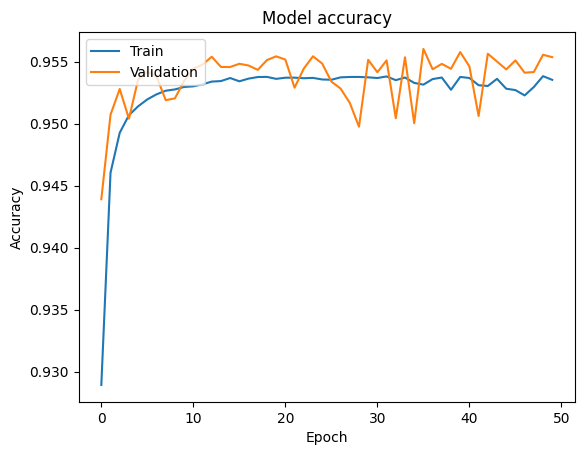

<Figure size 640x480 with 0 Axes>

In [21]:
# Plot the training and validation accuracy over the epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('acc_plo.jpg')

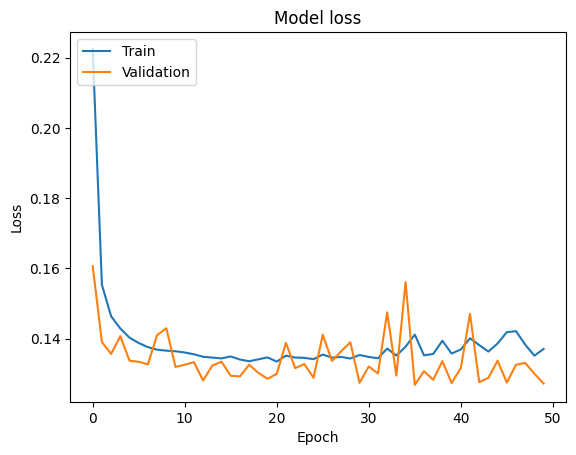

<Figure size 640x480 with 0 Axes>

In [22]:
# Plot the training and validation loss over the epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
plt.savefig('los_plo.jpg')

In [23]:
y_pred = model.predict(np.expand_dims(X_test, axis=2))

13871/13871 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step


In [24]:
y_pred_classes = np.argmax(y_pred, axis=1)

# Inverse the 'attacks' dictionary to map back numbers to names
inverse_attacks = {v: k for k, v in attacks.items()}

# Generate the classification report with attack names instead of numbers
class_report = classification_report(y_test, y_pred_classes, target_names=[inverse_attacks[i] for i in range(len(inverse_attacks))])

print(class_report)

              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99    323305
        DDoS       0.95      0.93      0.94     67690
    Scanning       0.93      0.85      0.89     14637
   Injection       0.67      0.81      0.73     20924
        MITM       1.00      0.27      0.43       263
     Malware       0.92      0.51      0.65     17022

    accuracy                           0.96    443841
   macro avg       0.91      0.73      0.77    443841
weighted avg       0.96      0.96      0.95    443841



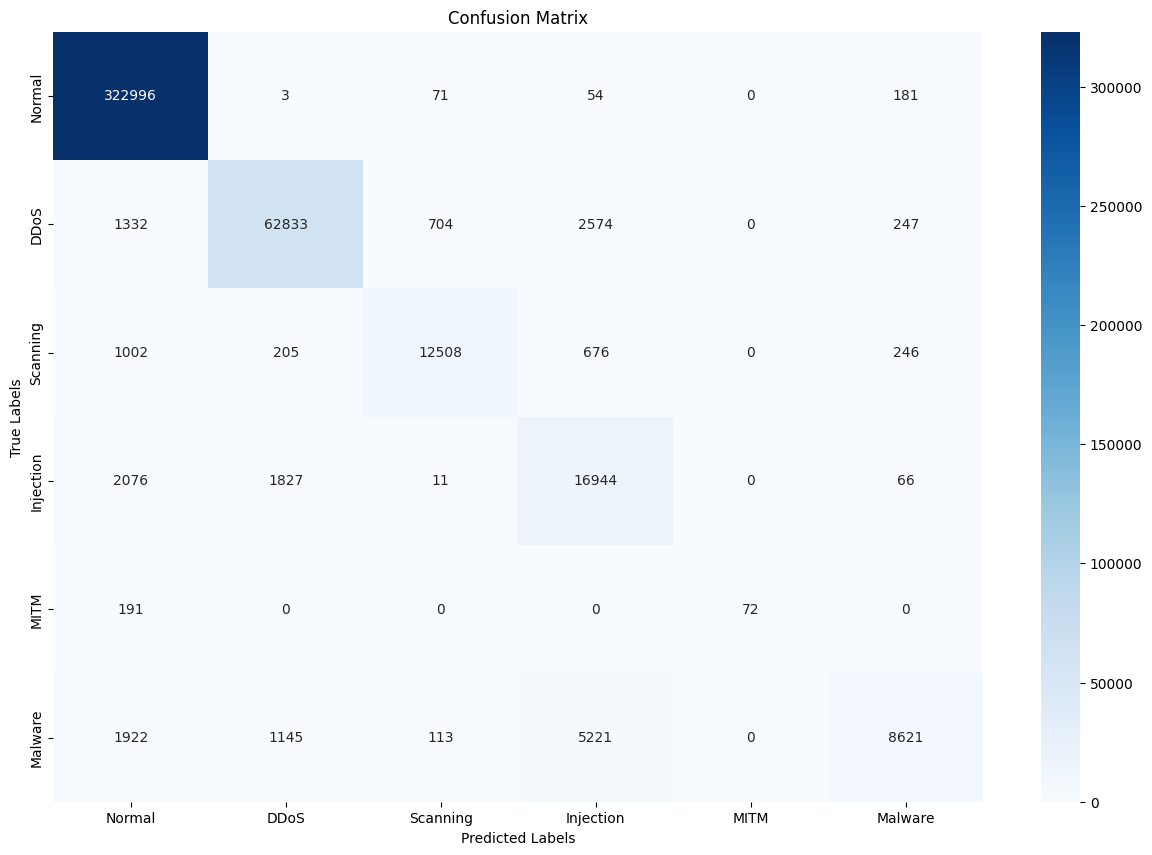

<Figure size 640x480 with 0 Axes>

In [25]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('con_mat.jpg')

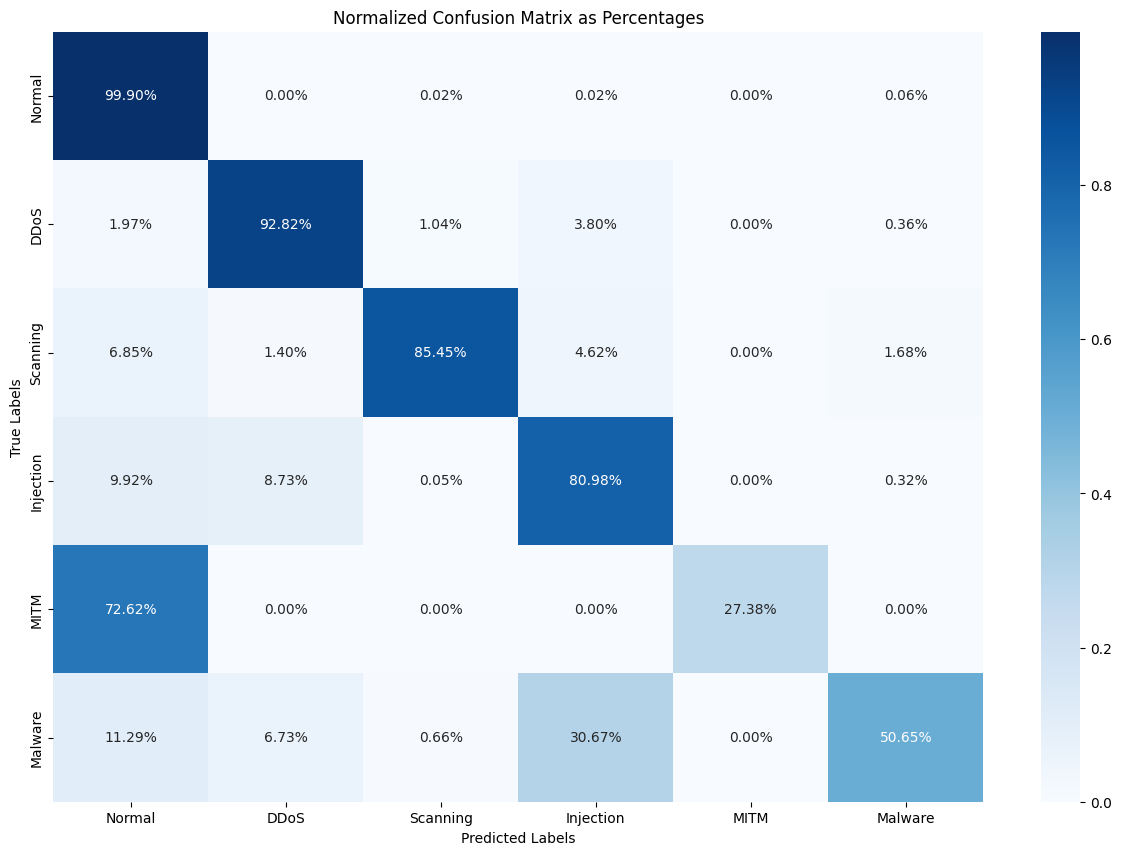

<Figure size 640x480 with 0 Axes>

In [26]:
# Compute the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Normalize the confusion matrix by dividing each value by the sum of its row (i.e., the number of true instances for each label)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Convert the 'attacks' dictionary to a list of class names ordered by the class number
class_names_ordered = [attack for attack, number in sorted(attacks.items(), key=lambda item: item[1])]

# Plot the heatmap using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names_ordered, yticklabels=class_names_ordered)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix as Percentages')
plt.show()
plt.savefig('con_per.jpg')